<h1 style="color:#333333; text-align:center; line-height: 0;"> <img style="right;" src="logo.png" width=18% height=18%> Advanced Control | Assignment 3 
</h1>
<br/><br/>

**First, familiarize yourself with [Rcognita](https://github.com/AIDynamicAction/rcognita) if you have not already done so. This assignment is based on this framework, so it's better to have an intuition about what's going on behind the scenes.**

In this homework asgn, we will address the problem of state estimation.
The goal of the following homework is to implement and test an extended Kalman filter for a mobile robot.

___Total points:___ 100

 
<h2 style="color:#A7BD3F;"> Section 1: Introduction to Kalman Filter </h2>

***

###  <font color="blue"> 1.0 Mathematical statement recap </font>

**Notation**

In this assignment we consider a controlled physical system described by the system of ordinary differential equations 
<a id='System'></a>
\begin{equation}
\begin{cases}
\dot{\boldsymbol x} = \boldsymbol f(\boldsymbol x, \boldsymbol u) + \boldsymbol w^x\\
\boldsymbol y = h(\boldsymbol x) + \boldsymbol w^y\\
\boldsymbol x(0)=\boldsymbol x_{0}\\
\end{cases}
\end{equation} where $x_{0}$ is the **initial state**, $\boldsymbol x$ and $\boldsymbol y$ are vectors of **system noise** and **observation noise** respectively. In the following table we introduce some basic notation. From now on, as it was before, we will write vectors in **bold**.
<a id='Notation'></a>

| Notation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| Description |
|:-----------------------:|-------------|
| $\boldsymbol f(\cdot, \cdot) : \mathbb{R}^{n} \times \mathbb{R}^{m} \rightarrow \mathbb{R}^{n}$ |A **state dynamic function**|
| $\boldsymbol x \in \mathbb{R}^{n} $ | An element of the **state space** of a controlled system of dimensionality $n$ |
| $\boldsymbol u \in \mathbb{R}^{m}$ | An element of the **action space** of a controlled system of dimensionality $m$ |
| $\boldsymbol y \in \mathbb{R}^{k}$ | An **observartion**|
| $\mathbb{X}\subset \mathbb{R}^{n} $| **State constraint set**|
| $\mathbb{U}\subset \mathbb{R}^{m} $| **Action constraint set**|
| $\boldsymbol h(\cdot): \mathbb{R}^{n} \rightarrow \mathbb{R}^{k}$ | **Observation function**  |
| $\kappa(\cdot) : \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ | **Policy** function |
| $\delta$ | **Sampling time** |
| $\boldsymbol x_k$   | A **state** at time $k\delta$: $\qquad\boldsymbol x (k \delta)$   |
| $\boldsymbol w^x$ , $\boldsymbol w^y$ | system noise and observation noise with covariation matricies $Q$ and $R$ respectively|

In this assignment in contrast to the previous one, we consider a dynamical model of a 3-wheel robot instead of a kinematic model. It means that now we assume the robot has mass, hence it has inertia as well. Therefore we can't control velocity of the robot directly and will apply pushing force and steering torque instead. The new system will take the following form:

$$\begin{cases}
\dot x_с & = v \cos \alpha \\
\dot y_с & = v \sin \alpha \\
\dot \alpha & = \omega \newline
\dot v & = \frac 1 m F  \\
\dot \omega & =  \frac 1 I M
\end{cases}$$
where $x_c$ and $y_c$ are coordinates of the center of mass, $v$ and $\omega$ are velocity of the center of mass and angular velocity respectively and $\alpha$ is a turning angle. $F$ and $M$ are pushing force and steering torque which we in consider the components of control $\boldsymbol u$

Recall that, in general, there is an **observation model** which can be interpreted as **measurement**, i.e., what is outputted "from" the system to the outside world is a function of the state. In particular, the output function may return just a part of the state vector. In many control tasks, it is necessary, however, to recover the information about the full state vector. The corresponding task is called **"state estimation"** and is usually addressed by the so called state observers. Perhaps the most common state observer is a **bayesian filter** that performs estimation using bayesian inference. Roughly speaking, it seeks to maximize the likelihood of the state estimate given the observed output. A particular variant of a baeysian filter is the extended kalman filter which we will implement from scratch further.

**Linearization:**
Since Kalman Filter works only in the linear case, we cannot apply it directly to our system. Instead, we assume that our system is described well enough by it's linearized analogue within the neighbourhood of point of linearization. 

First, we will discretize our system by time: 
$$
\frac{\boldsymbol x_{t+\Delta t}-\boldsymbol x_{t}}{\Delta t}=\boldsymbol f\left(\boldsymbol x_{t}, \boldsymbol u_{t}\right) \Rightarrow \boldsymbol x_{t+\Delta t}=\boldsymbol x_{t}+\boldsymbol f\left(\boldsymbol x_{t}, \boldsymbol u_{t}\right) \Delta t =: \bar{\boldsymbol f}(\boldsymbol x_t, \boldsymbol u_t)
$$

<a id='Jacobi'></a>

Introduce Jacobi matrix: 
$$
J_{\bar{f}}=\left(\begin{array}{cccc}
\frac{\partial \bar{f}_{1}}{\partial x_{1}} & \frac{\partial \bar{f}_{1}}{\partial x_{2}} & \cdots & \frac{\partial \bar{f}_{1}}{\partial x_{n}} \\
\frac{\partial \bar{f}_{2}}{\partial x_{1}} & \frac{\partial \bar{f}_{2}}{\partial x_{2}} & \cdots & \frac{\partial \bar{f}_{2}}{\partial x_{n}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial \bar{f}_{m}}{\partial x_{1}} & \frac{\partial \bar{f}_{m}}{\partial x_{2}} & \cdots & \frac{\partial \bar{f}_{m}}{\partial x_{n}}
\end{array}\right)
$$

In this notation we can obtain representation of $J_\bar{\boldsymbol f}$ in terms of $J_{\boldsymbol f}$:

$$ 
J_\bar{\boldsymbol f} = I + J_{\boldsymbol f}\Delta t 
$$

Let's denote $\boldsymbol{F}_{k}=\left.J_{\bar{f}}\right|_{\hat{\boldsymbol{x}}_{k-1 \mid k-1}, \boldsymbol{u}_{k}}$ and $\boldsymbol{H}_{k}=\left.\frac{\partial h}{\partial \boldsymbol{x}}\right|_{\hat{\boldsymbol{x}}_{k \mid k-1}}$


**Objective:**
Our objective is to create a **state estimator** capable of restoring the full vector of system state from the measurements obtained during the simulation, namely: to restore the coordinates of the robot from the measured linear and angular velocities.

**Algorithm description:**

From now and on $ \hat{ {x}}_{t \mid t-1} $ represents the estimate of $  {x}$ at time $ t$  given observations up to and including at time $ t-1$.
The algorithm can be basically divided into two main sections: **prediction part** and **correction part**. 

Summarize the **EKF**:

**Model**

$$
\begin{cases}
\dot{\boldsymbol x}(t) & =\boldsymbol f(\boldsymbol x(t), \boldsymbol u(t))+\boldsymbol w^x(t) & \boldsymbol w^x(t) & \sim \mathcal{N}( 0, {Q}(t)) \\
\boldsymbol y(t) & =\boldsymbol h(\boldsymbol x(t))+\boldsymbol w^y(t) & \boldsymbol w^y(t) & \sim \mathcal{N}( 0,  R(t))
\end{cases}
$$

**Discretized model**

$$
\begin{cases}
{\boldsymbol x_{t+1}} & =\bar{\boldsymbol f}(\boldsymbol x_t, \boldsymbol u_t)+\boldsymbol w^x_t & \boldsymbol w^x_t & \sim \mathcal{N}( 0, {Q}_t) \\
\boldsymbol y_{t+1} & =\boldsymbol h(\boldsymbol x_t)+\boldsymbol w^y_t & \boldsymbol w^y_t & \sim \mathcal{N}( 0,  R_t)
\end{cases}
$$

**Algorithm**
* Initialize:
$\\
\hat{ \boldsymbol{x}}\left(t_{0}\right)=E\left[ \boldsymbol{x}\left(t_{0}\right)\right],  {P}\left(t_{0}\right)=\operatorname{Var}\left[ \boldsymbol{x}\left(t_{0}\right)\right]
$ 
* Predict:
$
\hat{\boldsymbol{x}}_{k \mid k-1}\sim f\left(\hat{\boldsymbol{x}}_{k-1 \mid k-1}, \boldsymbol{u}_{k}\right) \\
\boldsymbol{P}_{k \mid k-1}=\boldsymbol{F}_{k} \boldsymbol{P}_{k-1 \mid k-1} \boldsymbol{F}_{k}^{\top}+\boldsymbol{Q}_{k} \\
$
* Correct:
$
\tilde{\boldsymbol{y}}_{k}=\boldsymbol{y}_{k}-h\left(\hat{\boldsymbol{x}}_{k \mid k-1}\right) \\
\boldsymbol{S}_{k}=\boldsymbol{H}_{k} \boldsymbol{P}_{k \mid k-1} \boldsymbol{H}_{k}^{\top}+\boldsymbol{R}_{k} \\
\boldsymbol{K}_{k}=\boldsymbol{P}_{k \mid k-1} \boldsymbol{H}_{k}^{\top} \boldsymbol{S}_{k}^{-1} \\
\hat{\boldsymbol{x}}_{k \mid k}=\hat{\boldsymbol{x}}_{k \mid k-1}+\boldsymbol{K}_{k} \tilde{\boldsymbol{y}}_{k} \\
\boldsymbol{P}_{k \mid k}=\left(\boldsymbol{I}-\boldsymbol{K}_{k} \boldsymbol{H}_{k}\right) \boldsymbol{P}_{k \mid k-1}
$

****

<a id='Motivation'></a>

___What's that all for?___

A little remark should be made here. One may know that if general, coordinates can be recovered from velocity by integration precedure. So why do we even want to apply bayesian machinery for this task? The problem is inevitable computation error which accumulates during time. So we need some tool that helps us to increase the precision of positioning based on knowledge of the system itself. Kalman filter is literally what solves this problem and obtains near-optimal estimations of the system under some mild conditions.

<h2 style="color:#A7BD3F;"> Section 2: Problems </h2>



***

### <font color="blue"> 2.1 Preparation of environment </font>
So, let's get started! The cell below contains some imports from Rcognita submodule that was cloned into your current directory in case you did everything correctly. Execute the following code and check out you don't have any errors.

In [1]:
"""
DO NOT MODIFY
"""
import warnings
with warnings.catch_warnings(record=True):
    import extras
    import matplotlib.animation as animation
    import matplotlib.pyplot as plt
    import numpy as np
    from numpy.linalg import inv
    from rcognita.rcognita import simulator
    from rcognita.rcognita import systems
    from rcognita.rcognita import controllers
    from rcognita.rcognita import loggers
    from rcognita.rcognita import visuals
    from rcognita.rcognita.utilities import on_key_press
    from rcognita.rcognita.utilities import dss_sim
    from rcognita.rcognita.utilities import rep_mat
    from rcognita.rcognita.utilities import uptria2vec
    from rcognita.rcognita.utilities import push_vec
    from scipy.optimize import minimize
    import argparse
    import scipy as sp
    

%matplotlib notebook
%load_ext autoreload
%autoreload 2

globals().update(vars(extras.update_globals_for_test()))

<h2 style="color:#A7BD3F;"> Section 2: Problems | Extended Kalman filter implementation </h2>

### <font color="blue"> 2.2 Problem 1 | Jacobi matrices computation </font>

This problem related to Jacobi matrices computation. The methods calculating the system and observation Jacobi matrices are supposed to be implemented in the class inherited from the `systems.Sys3WRobot`

****

**method:** 

```python
Jacobi_system_matrix(self, state, dt)
```

**input data**
* `state` - $\boldsymbol x$ is a vector of the state space on the basis of which the [Jacobi system matrix](#Jacobi) is calculated. **Dimension:** `[dim_state,]`
* `dt` - sampling time $\delta$ of type `float`

**output data**

* $J_\bar{f}$ - [Jacobi system matrix](#Jacobi) of dimension `[dim_state,dim_state]`

****

**method:** 
```python
Jacobi_observation_matrix(self, ?)
```

* Does it depend on something? What dimension does it have? Calculate it yourself by hands and implement it

**output data**

* $J_h$ - Jacobi observation matrix 
****
Your task is to implement `Jacobi_system_matrix` and `Jacobi_observation_matrix` methods.

Your solution should meet **three criteria**:

1. Low enough $J_\bar{f}$ computation error on the test vector set
2. $\det(J_hJ_h^T) = 1$
3. Correct shape of $J_h$

During the testing you will receive a hint in case your solution is not correct in some sence.

In [2]:
class Sys3WRobotLab(systems.Sys3WRobot):
    def Jacobi_system_matrix(
        self, 
        state, 
        dt
    ):
        #############################################
        # YOUR CODE BELOW
        #############################################
        v = state[3]
        alpha = state[2]
        
        Jf = np.zeros((self.dim_state,self.dim_state))
        Jf[0,:] = np.array([0,0,-v*np.sin(alpha),np.cos(alpha),0])
        Jf[1,:] = np.array([0,0,v*np.cos(alpha),np.sin(alpha),0])
        Jf[2,:] = np.array([0,0,0,0,1])
        I = np.eye(self.dim_state)
        
        return I + Jf *dt
        #############################################
        # YOUR CODE ABOVE
        #############################################

    def Jacobi_observation_matrix(self):
        #############################################
        # YOUR CODE BELOW
        #############################################
        Jh = np.array([[0,0,0,1,0],
                       [0,0,0,0,1]])
        return Jh
        #############################################
        # YOUR CODE ABOVE
        #############################################

### <font color="blue"> 2.3 Problem 1 | Testing of the Jacobi matrix computation methods </font>

In [3]:
my_system = Sys3WRobotLab(
        sys_type="diff_eqn",
        dim_state=dim_state,
        dim_input=dim_input,
        dim_output=2,
        dim_disturb=dim_disturb,
        pars=[m, I],
        ctrl_bnds=ctrl_bnds,
        is_dyn_ctrl=is_dyn_ctrl,
        is_disturb=is_disturb,
        pars_disturb=[],
    )

grade1 = extras.test_first_task_procedure(lambda x: my_system.Jacobi_system_matrix(x, 0.1), my_system.Jacobi_observation_matrix)

[[2.23606798 0.         0.05752796 0.20080548 0.        ]
 [0.         2.23606798 0.12768654 0.09837256 0.        ]
 [0.         0.         2.23606798 0.         0.2236068 ]
 [0.         0.         0.         2.23606798 0.        ]
 [0.         0.         0.         0.         2.23606798]]
8.744055638595422e-09
False True True


<text style=color:red> Something went wrong.         Check out criteria 1. Grade is 0 out of 25.</text>

### <font color="blue"> 2.3 Problem 2 | Kalman filter implementation </font>



In this task we will implement Kalman Filter almost from the scratch. Let's take a look at the architecture to clarify how it assumed to be implemented and also recall main rcognita architecture features.

<img style="left;" src="architecture2.svg" width=80% height=80%>

Here are some references:

* **Definition** of system you can find in `rcognita/rcognita/systems.py`. In this assignment `Sys3WRobot` class is used.
* **Visualizer** is a class `Animator3WRobot_traj` located in `./extras.py` inherited from `Animator3WRobot` located in `rcognita/rcognita/visuals.py`.
* **Simulator** is located in `rcognita/rcognita/simulator.py` and performs ground-truth simulation with adaptive integration step (Like, real world performs the same computations with step size of Planck time 😊)
* **Controller** here is just some manual controller that was implementing only for **EKF** testing purposes. After you pass the assignment you will sure be able to play around with that in `extras.py` module. It is defined inside `CtrlPredefined3WRobot` class.
* **Sampler part** is hard-coded inside the `compute_estimate` method which just checks that estimation performs with sampling time `delta` - digital controller period.
* **Observer** is what you will implement in the following task!

Your task here is to implement two main methods of extended Kalman filter:
1. **state prediction stage method**:

```python 
predict_state(self, action: numpy.ndarray) -> None
```  

$
\hat{\boldsymbol{x}}_{k \mid k-1}\sim \boldsymbol f\left(\hat{\boldsymbol{x}}_{k-1 \mid k-1}, \boldsymbol{u}_{k}\right) \\
\boldsymbol{P}_{k \mid k-1}=\boldsymbol{F}_{k} \boldsymbol{P}_{k-1 \mid k-1} \boldsymbol{F}_{k}^{\top}+\boldsymbol{Q}_{k} \\
$
where prior state estimation computes given the received action. It returns nothing and assigns obtained prior estimation to variables `self.prior_state_est` and `self.prior_est_cov`

Here
$\hat{\boldsymbol{x}}_{k \mid k-1}\sim \boldsymbol f\left(\hat{\boldsymbol{x}}_{k-1 \mid k-1}, \boldsymbol{u}_{k}\right)$
means that prior estimation of current state is generated by integration with some suitable schema. You may use Euler schema as it was proposed in previous assignment:
$$
\hat{\boldsymbol{x}}_{k \mid k-1} =  \hat{\boldsymbol{x}}_{k-1 \mid k-1} + \delta \boldsymbol f\left(\hat{\boldsymbol{x}}_{k-1 \mid k-1}, \boldsymbol{u}_{k}\right)
$$

2. **state correction method**:

```python 
correct_state(self, observation: numpy.ndarray) -> None
```  
$\text{preliminary computations}
\begin{cases}
\tilde{\boldsymbol{y}}_{k}=\boldsymbol{y}_{k}-\boldsymbol h\left(\hat{\boldsymbol{x}}_{k \mid k-1}\right) \\
\boldsymbol{S}_{k}=\boldsymbol{H}_{k} \boldsymbol{P}_{k \mid k-1} \boldsymbol{H}_{k}^{\top}+\boldsymbol{R}_{k} \\
\boldsymbol{K}_{k}=\boldsymbol{P}_{k \mid k-1} \boldsymbol{H}_{k}^{\top} \boldsymbol{S}_{k}^{-1} \\
\end{cases}\\
\text{main computations}
\begin{cases}
\hat{\boldsymbol{x}}_{k \mid k}=\hat{\boldsymbol{x}}_{k \mid k-1}+\boldsymbol{K}_{k} \tilde{\boldsymbol{y}}_{k} \\
\boldsymbol{P}_{k \mid k}=\left(\boldsymbol{I}-\boldsymbol{K}_{k} \boldsymbol{H}_{k}\right) \boldsymbol{P}_{k \mid k-1}
\end{cases}
$

where posterior state estimation computes. It also assumed to be a procedure that returns nothig and
* evaluates `self.posterior_state_est` - updated (posterior) state estimation $\hat{\boldsymbol{x}}_{k \mid k}$
* evaluates `self.posterior_est_cov` - updated (posterior) covariance estimation $\boldsymbol{P}_{k \mid k}$

****

Important remark: in the algoirthm description system noise covariance matrix and observation covariance matrix are assumed to be known. But in general those are hyperparameters and should be tuned manually. In this work we give a choice to play around with them. But don't worry - you will obtain good results fast in case if you implement Kalman filter correctly. 

**Hint:** we add a standard gaussian noise to observation with dispersion 1 and expectation 0.

In [4]:
sys_noise_cov = np.eye(5) ###---Your code is here---###

observ_noise_cov = np.eye(2) ###---Your code is here---###

state_cov = np.zeros((5,5)) ###---Your code is here---###

In [5]:
class KalmanFilter:
    def __init__(self, 
                 t0,
                 delta,
                 my_sys, 
                 sys_noise_cov, 
                 observ_noise_cov,
                 prior_est_cov,
                 state_init,
                ):
        
        self.my_sys = my_sys ###---system initialization---###
        self.dim_output = my_sys.dim_output ###---controlled system output dimensionality---###
        
        
        self.sys_noise_cov = sys_noise_cov ###---system noise covariance matrix---###
        self.observ_noise_cov = observ_noise_cov ###---observation noise covariance matrix---###
        self.prior_state_est = None ###---prior estimation of a state. Unnecessaty for initialization---###
        self.prior_est_cov = prior_est_cov ###---system noise covariance matrix---###
        
        self.estimation_buffer = []
        self.sample_array = []
        
        self.est_clock = t0
        self.delta = delta
        self.eps = 1e-8
        
        ############################
        # Main initialization part #
        ############################
        self.h = np.array([[0,0,0,1,0],
                           [0,0,0,0,1]])
        
        self.posterior_state_est = state_init
        self.posterior_est_cov = prior_est_cov
        print(self.posterior_state_est)
        ############################
        # Main initialization part #
        ############################
        
        
    def predict_state(self, action):
        #############################################
        # YOUR CODE BELOW
        #############################################
        
        try:
            J = self.my_sys.Jacobi_system_matrix(self.posterior_state_est,self.delta)
            self.prior_state_est = self.posterior_state_est + self.delta * my_sys._state_dyn([],self.posterior_state_est,action)
            self.prior_est_cov = J @ self.posterior_est_cov @ J.T + self.sys_noise_cov
            f = open('debug.txt', 'a')
            f.write('GOOOOOOD \n')
            f.close()
        except Exception as er:
            f = open('debug.txt', 'w')
            f.write('Err in first \n')
            f.close()

        #############################################
        # YOUR CODE ABOVE
        #############################################

    def correct_state(self, observation):
        #############################################
        # YOUR CODE BELOW
        #############################################
        try:
            print("first mess startet")
            H = self.my_sys.Jacobi_observation_matrix()

            y = observation - self.h @ self.prior_state_est
            S = H @ self.prior_est_cov @ H.T + self.observ_noise_cov
            K = self.prior_est_cov @ H.T @ np.linalg.inv(S)

            self.posterior_state_est = self.prior_state_est + K @ y
            self.posterior_est_cov = (np.eye(5) - K @ H) @ self.prior_est_cov
            print("first mess ended")
        except Exception as er:
            f = open('debug.txt', 'w')
            f.write( str(er) + ' \n')
            f.close()
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
    def compute_estimate(self, t, observation, action):
        
        
        time_in_sample = t - self.est_clock

        if time_in_sample >= self.delta-self.eps:
            
            self.sample_array.append([time_in_sample, self.delta, (self.delta - time_in_sample)/time_in_sample])
            self.est_clock = t
            
            self.predict_state(action) ###------------------------------prediction stage
            self.correct_state(observation[-self.dim_output:]) ###----------correction stage
            
            self.estimation_buffer.append(self.posterior_state_est)
            
        return self.posterior_state_est

In [6]:
my_system_for_EKF = Sys3WRobotLab(
        sys_type="diff_eqn",
        dim_state=dim_state,
        dim_input=dim_input,
        dim_output=2,
        dim_disturb=dim_disturb,
        pars=[m, I],
        ctrl_bnds=ctrl_bnds,
        is_dyn_ctrl=is_dyn_ctrl,
        is_disturb=is_disturb,
        pars_disturb=[],
    )

### Main Loop

[-5.          0.         -2.35619449  0.          0.7       ]


<IPython.core.display.Javascript object>


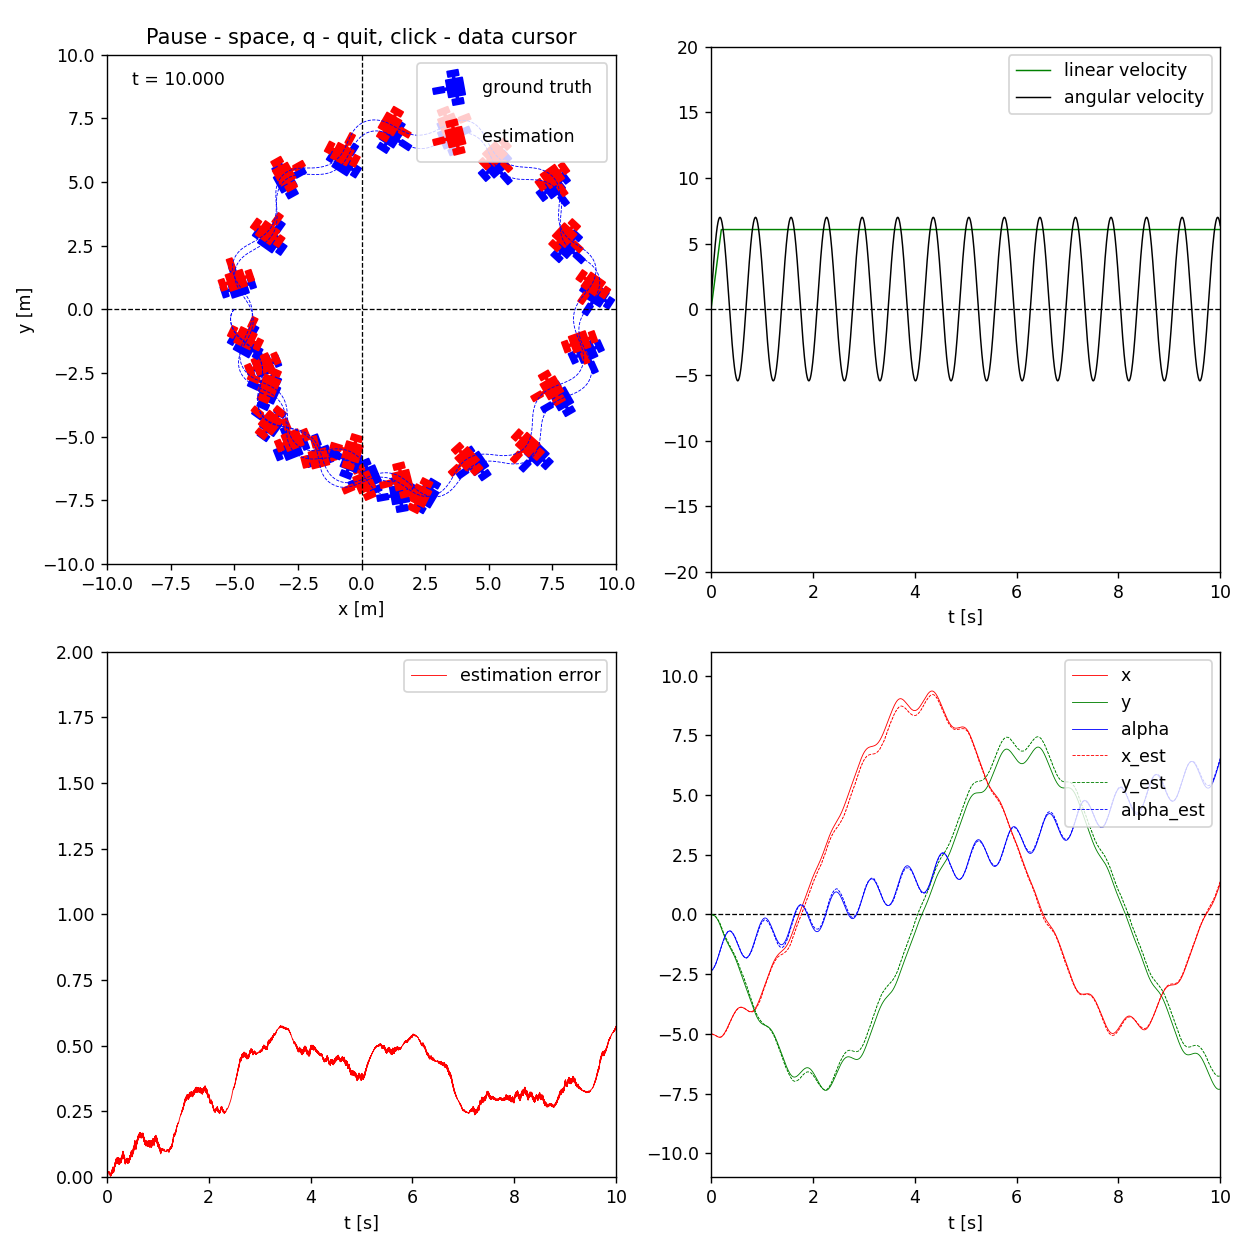

In [7]:
globals().update(vars(extras.update_globals_for_test()))

state_full_init = my_simulator.state_full
state_est_init = state_full_init
my_state_estimator = KalmanFilter(t0, dt, my_system_for_EKF, sys_noise_cov, observ_noise_cov, state_cov, state_est_init)



my_animator = extras.Animator3WRobot_traj(objects=(my_simulator,
                                                 my_sys,
                                                 my_state_estimator,
                                                 my_ctrl_nominal,
                                                 my_ctrl_benchm,
                                                 datafiles,
                                                 controllers.ctrl_selector,
                                                 my_logger),
                                        pars=(state_init,
                                              action_init,
                                              t0,
                                              t1,
                                              state_full_init,
                                              state_est_init,
                                              xMin,
                                              xMax,
                                              yMin,
                                              yMax,
                                              ctrl_mode,
                                              action_manual,
                                              Fmin,
                                              Mmin,
                                              Fmax,
                                              Mmax,
                                              Nruns,
                                              is_print_sim_step, 
                                              is_log_data, 0, []))

anm = animation.FuncAnimation(my_animator.fig_sim,
                              my_animator.animate,
                              init_func=my_animator.init_anim,
                              blit=False, interval=dt/1e6, repeat=False, save_count = 100)

my_animator.get_anm(anm)

cId = my_animator.fig_sim.canvas.mpl_connect('key_press_event', lambda event: on_key_press(event, anm))

anm.running = False

my_animator.fig_sim.tight_layout()

plt.show()

#### Grading

metric here is $\int ||\boldsymbol x -\hat{ \boldsymbol x}|| dt$ where it's perfect value is assumed to be equal 33. To earn points, beat this metric or make a result at most 20 percent worse. So, the least amount of points you can receive for that task is 60.

In [9]:
est_full_trajectory = np.array(my_animator.est_full_trajectory)
full_trajectory = np.array(my_animator.full_trajectory)
trajectory = (full_trajectory-est_full_trajectory)[:, 3:]
tail_length = len(trajectory) - 2
tail = np.array(trajectory)[-tail_length:, :2]
norms = np.linalg.norm(tail, axis=1)
integral_metric = norms.sum() * 0.01
grade2 = extras.integral_grading((est_full_trajectory - full_trajectory)[:, 3:])

<text style=color:blue> Perfect! Grade is 75 out of 75. </text>

In [10]:
integral_metric

33.563357904697334

In [11]:
print(f"Final grade is: {grade1 + grade2}")

Final grade is: 75


## Questions?

Reach out to **Ilya Osokin (@elijahmipt)** or **Georgiy Malaniya (@odinmaniac)** on Telegram.